In [92]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt

## Estimação de parâmetros por experimento

Temos um sistema massa-mola governado pela Equação 

$$
m\ddot{x} + c\dot{x} + kx = 0
$$

Reescrevendo tal equação em termos de $\xi$ e $\omega$ obtemos

$$
\ddot{x} + 2\xi \omega \dot{x} + \omega^2 x = 0
$$

Em que

$$
\omega = \sqrt{\dfrac{k}{m}} \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
\xi = \dfrac{c}{2\sqrt{km}}
$$

E um termo auxiliar $\mu$ que utilizaremos para facilitar a notação

$$
\mu = \sqrt{1-\xi^2}
$$

E então conseguimos descrever a resposta da solução em função do tempo com condições iniciais $x_0$ e $v_0$ dependendo do parâmetro $\xi$. 
Aqui iremos abordar apenas quando temos o oscilamento sub-amortecido ($0 < \xi < 1$), de modo que a solução é descrita por

$$
x(t) = \exp \left(-\xi \omega t\right) \left[\underbrace{x_0}_{A} \cos \mu \omega t + \underbrace{\left(\frac{\xi}{\mu} x_0 + \frac{1}{\mu \omega} v_0\right)}_{B}\sin \mu \omega t\right]
$$

In [93]:
def solucao_sub_amortecida(xi:float, wn:float, t, x0:float, v0:float):
    mu = np.sqrt(1-xi**2)
    x = sp.exp(-xi*wn*t) * (x0 * sp.cos(mu*wn*t) + (xi*x0/mu + v0/(mu*wn)) * sp.sin(mu*wn*t))
    return x

def solucao_x(xi:float, wn:float, x0:float, v0:float):
    t = sp.symbols("t")
    if 0 < xi < 1:
        x = solucao_sub_amortecida(xi, wn, t, x0, v0)
    else:
        raise Exception("The value of xi must be in (0, 1). Received %.3f" % xi)
    return sp.lambdify(t, x)

def solucao_v(xi:float, wn:float, x0:float, v0:float):
    t = sp.symbols("t")
    if 0 < xi < 1:
        x = solucao_sub_amortecida(xi, wn, t, x0, v0)
    else:
        raise Exception("The value of xi must be in (0, 1). Received %.3f" % xi)
    v = sp.diff(x, t)
    return sp.lambdify(t, v)

Então pegaremos um exemplo com as seguintes condições iniciais

$$
\xi = 0.2 \ \ \ \ \ \ \ \ \ \ \omega = 1
$$

$$
x_0 = 1 \ \ \ \ \ \ \ \ \ \ v_0 = 1
$$



In [94]:
def initial_conditions():
    wn = 1
    xi = 0.2
    x0, v0 = 1, 1
    return xi, wn, x0, v0

xi, wn, x0, v0 = initial_conditions()
Tn = 2*np.pi/wn
TotalTime = 10*Tn
nplot = 1029
tplot = np.linspace(0, TotalTime, nplot)

Text(0.5, 1.0, 'Solução exata para os parâmetros encontrados')

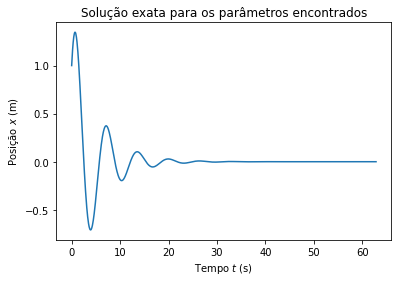

In [95]:
xplot = solucao_x(xi, wn, x0, v0)(tplot)
plt.plot(tplot, xplot)
plt.xlabel("Tempo $t$ (s)")
plt.ylabel("Posição $x$ (m)")
plt.title("Solução exata para os parâmetros encontrados")

## Dados ruidosos

Por enquanto não temos os dados de nenhum experimento e dessa forma iremos adicionar um ruido artificial à solução exata já conhecida.
E então compararemos os valores exatos dos parâmetros com aqueles estimados apenas pelos valores nos pontos.

No caso teremos $n$ valores de $x$ medidos ao longo do tempo, formando os pontos $(t_i, \ x_i)$.

In [96]:
nsample = 1000 # Quantidade de pontos medidos durante o experimento
tsample = np.linspace(0, TotalTime, nsample)
incerteza = 1e-1  # Medimos em metros, e temos a incerteza de 100 mm
xexact = solucao_x(xi, wn, x0, v0)(tsample)
xsample = np.copy(xexact) + incerteza*(2*np.random.rand(nsample)-1)  # Valores lidos
print("Distância média linear entre pontos = %.2e" % np.mean(np.abs(xsample-xexact)))
print("         Distância média quadrática = %.2e" % np.mean((xsample-xexact)**2))
print("                   Norma quadrática = %.2e" % np.linalg.norm(xsample-xexact))

Distância média linear entre pontos = 4.96e-02
         Distância média quadrática = 3.27e-03
                   Norma quadrática = 1.81e+00


In [97]:
xi_exact = xi
mu_exact = np.sqrt(1-xi**2)
wn_exact = wn
x0_exact = x0
v0_exact = v0
A_exact = x0
B_exact = xi*x0/mu_exact + v0/(mu_exact*wn)

Text(0.5, 1.0, 'Valores ruidosos produtos artificialmente')

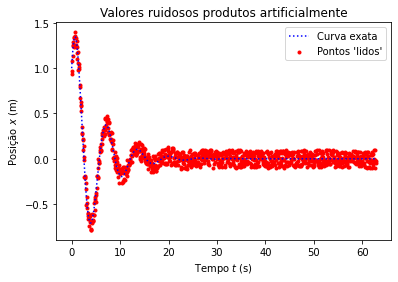

In [98]:
plt.scatter(tsample, xsample, color="r", marker=".", label="Pontos 'lidos'")
plt.plot(tsample, xexact, color="b", ls="dotted", label="Curva exata")
plt.xlabel("Tempo $t$ (s)")
plt.ylabel("Posição $x$ (m)")
plt.legend()
plt.title("Valores ruidosos produtos artificialmente")

## Estimativa do parâmetro $\xi$ usando os valores ruidosos

Como sabemos que $\xi<1$ teremos a solução dada por

$$
x(t) = \exp \left(-\xi \omega t\right) \left[A \cos \left(\mu \omega t\right) + B \sin \left(\mu \omega t\right)\right]
$$

Com constantes $A$ e $B$ que vêm das condições iniciais.

Então, como não sabemos os parâmetros $A$, $B$, $\xi$ e $\omega$ quando são obtidos os resultados experimentais, vamos utilizar os **métodos dos mínimos quadráticos** para estima-los usando os valores ruidosos obtidos mais acima.

Seja $J$ a função que soma os quadrados das diferenças, teremos

$$
J(A, B, \xi, \omega) = \dfrac{1}{2} \sum_{i} w_{i}\left(x(t_{i}) - x_i\right)^{2}
$$

Em que $(t_i, \ x_i)$ são os valores medidos pelo experimento. Os valores de $w_i$ são os **pesos** que iremos colocar pois consideraremos que os primeiros pontos lidos são mais importantes que os ultimos, pois o ruido afeta bastante os ultimos valores lidos e queremos diminuir esse efeito do ruido.
De modo geral usaremos

$$
w_{i} = \exp\left(-\dfrac{t_{i}^2}{T_n^2}\right) \ \ \ \ \ \ \ \ \ \ T_n = \dfrac{2\pi}{\omega}  
$$

Onde $T_{n}$ é o período de uma oscilação natural.

Assim, para minimizar a função $J$ podemos pegar a derivada (no caso multidimensional, o gradiente) de $J$ e igualar a $0$

$$
\nabla J = \vec{0} \Leftrightarrow \dfrac{\partial J}{\partial q_i} = 0
$$

E então pegar uma expressão pra encontrar os parâmetros.

Para evitar o calculo de derivadas à mão, utilizaremos a biblioteca ```sympy``` para fazer os calculos algébrico das derivadas.
Caso seja necessário aumentar a velocidade do código (performance) por exemplo, seria interessante de ter as fórmulas das derivadas e montar manualmente os códigos para evitar re-calculo. No nosso caso, não faremos isso.


In [99]:
X = sp.symbols("A B xi wn")
t = sp.symbols("t")
A, B, xi, wn = X

mu = sp.sqrt(1-xi**2)
x = sp.exp(-xi*wn*t)*(A*sp.cos(mu*wn*t) + B*sp.sin(mu*wn*t))

Para calcular as derivadas, será util as expressões

$$
Gx = \nabla x = \begin{bmatrix}
\dfrac{\partial x}{\partial A} \\ \dfrac{\partial x}{\partial B} \\ \dfrac{\partial x}{\partial \xi} \\ \dfrac{\partial x}{\partial \omega} 
\end{bmatrix}
$$

$$
GGx = \nabla \nabla x = \begin{bmatrix}
\dfrac{\partial^2 x}{\partial A^2} & \dfrac{\partial^2 x}{\partial A \partial B} & \dfrac{\partial^2 x}{\partial A \partial \xi} & \dfrac{\partial^2 x}{\partial A \partial \omega}  \\  & \dfrac{\partial^2 x}{\partial B^2} & \dfrac{\partial^2 x}{\partial B \partial \xi} & \dfrac{\partial^2 x}{\partial B \partial \omega} \\ & & \dfrac{\partial^2 x}{\partial \xi^2} & \dfrac{\partial^2 x}{\partial \xi \partial \omega}  \\ \text{sym} & & & \dfrac{\partial^2 x}{\partial \omega^2} 
\end{bmatrix}
$$

In [100]:
Gx = sp.derive_by_array(x, X)
GGx = sp.derive_by_array(Gx, X)
x = sp.lambdify((t, A, B, xi, wn), x, "numpy")
Gx = sp.lambdify((t, A, B, xi, wn), Gx, "numpy")
GGx = sp.lambdify((t, A, B, xi, wn), GGx, "numpy")

Então calculando a derivada de $J$:

$$
\nabla J = \sum_{i}\left(x(t_i) - x_i\right) \nabla x(t_i)
$$

Mas como essa é uma equação não linear, iremos utilizar o método de Newton para encontrar tal raiz.
Em resumo ele consiste em encontrar a raiz de $f(x)$ então

$$
x_{j+1} = x_{j} - \dfrac{f(x_j)}{f'(x_j)}
$$

No nosso caso, partindo de uma estimativa $X_{j} = (A_{j}, \ B_{j}, \ \xi_{j}, \ \omega_{j})$ calculamos os próximos passos usando

$$
\underbrace{\begin{bmatrix}
A_{j+1} \\ B_{j+1} \\ \xi_{j+1} \\ \omega_{j+1}
\end{bmatrix}}_{X_{j+1}} = 
\underbrace{\begin{bmatrix}
A_{j} \\ B_{j} \\ \xi_{j} \\ \omega_{j} 
\end{bmatrix}}_{X_{j}} - \left[\nabla \nabla J\right]^{-1} \cdot \left[\nabla J\right]
$$

With 

$$
\nabla \nabla J = \sum w_i \left[\nabla x \otimes \nabla x + x \nabla \nabla x\right] - \sum w_i x_i \nabla \nabla x
$$

Em uma foma matricial podemos colocar que

$$
\left[L\right]_{k} = x(t_k)
$$

$$
\left[dL\right]_{ik} = \dfrac{\partial x(t_k)}{\partial q_{i}}  = \left[Gx\right]_{i}(t_k)
$$

$$
\left[ddL\right]_{ijk} = \dfrac{\partial^2 x(t_{k})}{\partial q_{i} \partial q_{j}} = \left[GGx\right]_{ij}(t_k)
$$

$$
\left[x\right]_{k} = x_{k}
$$

$$
\left[W\right]_{ik} = \begin{cases}w_{i} \ \ \ \ \text{se} \ i = k \\ 
0 \ \ \ \ \ \ \text{senão}\end{cases}
$$

E então teremos

$$
\left[ \nabla J \right] = \left[dL\right] \cdot \left[W\right] \cdot \left[L\right] - \left[dL\right] \cdot \left[W\right] \cdot \left[x\right]
$$

$$
\left[ \nabla \nabla J \right] = \left[dL\right] \cdot \left[W\right] \cdot \left[dL\right] + \left[ddL\right] \cdot \left[W\right] \cdot \left[L\right] - \left[ddL\right] \cdot \left[W\right] \cdot \left[x\right]
$$

In [101]:

def getMB(tvals, xvals, Xj):
    n = len(xvals)
    m = len(Xj)
    L = np.zeros(n, dtype="float64")
    dL = np.zeros((m, n), dtype="float64")
    ddL = np.zeros((m, m, n), dtype="float64")
    Tn = 2*np.pi/Xj[3]
    weight = np.exp(-(tvals/Tn)**2)
    # weight = np.ones(len(tvals))
    for i, ti in enumerate(tvals):
        L[i] = x(ti, Xj[0], Xj[1], Xj[2], Xj[3])
        dL[:, i] = np.array(Gx(ti, Xj[0], Xj[1], Xj[2], Xj[3]), dtype="float64")
        ddL[:, :, i] = np.array(GGx(ti, Xj[0], Xj[1], Xj[2], Xj[3]), dtype="float64")
    
    M = dL @ np.diag(weight) @ dL.T - ddL @ np.diag(weight) @ xvals + ddL @ np.diag(weight) @ L.T
    B = dL @ np.diag(weight) @ L.T - dL @ np.diag(weight) @ xvals
    return M, B

#### Estimar o ponto inicial

Agora, para o método de Newton, precisamos do ponto inicial $X_0 = (A_{0}, \ B_{0}, \ \xi_{0}, \ \omega_{0})$ o qual vamos procurar a solução.

Para a estimativa de $A_{0}$, como $x(t = 0) = A$ então podemos apenas pegar o primeiro ponto

$$
A_{0} = x_0
$$

In [102]:
A0 = xsample[0]
print("A estimado = ", A0)
print("   A exato = ", A_exact)

A estimado =  0.9382163371864775
   A exato =  1


Agora, pra $B$ é mais complicado e então primeiro pegaremos $\xi_{0}$ e $\omega_{0}$.
Sejam $\alpha$ e $\beta$ os índices tais que

$$x_{\alpha} = \max_{i} x_{i}$$

$$x_{\beta} = \min_{i} x_{i}$$

Como sabemos, a distância no tempo entre dois picos é equivalente a meio período, de forma que teremos

$$
\dfrac{1}{2}T = |t_{\beta} - t_{\alpha}|
$$

De forma que $T$ é o tempo de uma oscilação

$$
T = \dfrac{2\pi}{\omega_{d}} = \dfrac{2\pi}{\mu \omega} \Rightarrow \mu \omega = \dfrac{2\pi}{T} = \dfrac{\pi}{|t_{\beta} - t_{\alpha}|} 
$$

Por outro lado, sabemos que o decaimento é exponencial, de forma para algum $C = C(A, B)$ que

$$
x_{\alpha} = C \exp\left(-\xi \omega t_\alpha\right)
$$
$$
x_{\beta} = -C \exp\left(-\xi \omega t_\beta\right)
$$

Dividindo uma equação pela outra

$$
\exp \left(-\xi \omega \left(t_{\beta} - t_{\alpha}\right)\right) = \dfrac{-x_{\beta}}{x_{\alpha}}
$$

$$
\xi \omega = \dfrac{-1}{t_{\beta} - t_{\alpha}} \cdot \ln \left(\dfrac{-x_{\beta}}{x_{\alpha}}\right)
$$

Elevando ao quadrado ambas equações e as somando obteremos

$$
\xi^2 \omega^2 + \mu^2 \omega^2 = \omega^2 = \dfrac{\pi^2}{\left(t_{\beta}-t_{\alpha}\right)^2} + \dfrac{1}{(t_{\beta}-t_{\alpha})^2} \ln^2 \left(\dfrac{-x_{\beta}}{x_{\alpha}}\right)
$$

$$
\boxed{\omega_{0} =\dfrac{1}{|t_{\beta} - t_{\alpha}|} \sqrt{\pi^2 + \ln^2 \left(\dfrac{-x_{\beta}}{x_{\alpha}}\right)}}
$$

In [103]:
alpha = np.where(xsample == np.max(xsample))[0][0]
beta = np.where(xsample == np.min(xsample[alpha:]))[0][0]
alpha = np.where(xsample == np.max(xsample[beta:]))[0][0]
xalpha = xsample[alpha]
xbeta = xsample[beta]
talpha = tsample[alpha]
tbeta = tsample[beta]
wn0 = np.sqrt(np.pi**2 + np.log(-xbeta/xalpha)**2)/np.abs(tbeta-talpha)
print("wn estimado = ", wn0)
print("   wn exato = ", wn_exact)

wn estimado =  0.9551168027661089
   wn exato =  1


E então o valor de $\mu$ e $\xi$

$$
\mu_{0} = \dfrac{\pi}{\omega_{0} |t_{\beta} - t_{\alpha}|}
$$

$$
\xi_{0} = \sqrt{1-\mu_{0}^2}
$$

In [104]:
mu0 = np.pi/(wn0*np.abs(tbeta-talpha))
xi0 = np.sqrt(1-mu0**2)
print("xi estimado = ", xi0)
print("   xi exato = ", xi_exact)
print("mu estimado = ", mu0)
print("   mu exato = ", mu_exact)

xi estimado =  0.16230330225295225
   xi exato =  0.2
mu estimado =  0.9867409174032395
   mu exato =  0.9797958971132712


Por ultimo, queremos encontrar o valor de $B_0$. Sabemos que a amplitude total é dada por

$$
C = \sqrt{A^2 + B^2}
$$

Tal que, para algum $\phi$, podemos reescrever a solução como

$$
x(t) = C \exp\left(-\xi \omega t\right) \sin(\mu \omega t + \phi )
$$

E então teremos

$$
x(t_{\alpha}) = C \exp \left(-\xi \omega t_{\alpha}\right) \underbrace{\sin \left(\mu \omega t_{\alpha} + \phi\right)}_{1}
$$

$$
\sqrt{A^2 + B^2} = C = \dfrac{x(t_{\alpha})}{\exp \left(-\xi \omega t_{\alpha}\right)}
$$

$$
\Rightarrow B = \sqrt{\dfrac{x(t_{\alpha})^2}{\exp \left(-2\xi \omega t_{\alpha}\right)} - A^2}
$$

E para decidir o sinal de $B$, usaremos o valor mais próximo da origem:

$$
\begin{cases} 
B > 0 \ \ \ \ \text{se} \ \ t_{\alpha} < t_{\beta}\\
B < 0 \ \ \ \ \text{senão} 
\end{cases}
$$

In [105]:
C0 = xalpha/np.exp(-xi0*wn0*talpha)
B0 = np.sqrt( np.abs(C0**2-A0**2) )
print("B estimado = ", B0)
print("   B exato = ", B_exact)

B estimado =  1.0904157723174188
   B exato =  1.2247448713915892


Logo montamos o vetor inicial $X$ que vamos utilizar para iterar

In [106]:
X = np.array([A0, B0, xi0, wn0])
X_exact = np.array([A_exact, B_exact, xi_exact, wn_exact])
print("X estimado = ", X)
print("   X exato = ", X_exact)

X estimado =  [0.93821634 1.09041577 0.1623033  0.9551168 ]
   X exato =  [1.         1.22474487 0.2        1.        ]


Agora é resolver iterando. Mas primeiro vamos definir funções para avaliar a solução

In [107]:
def compute_residuo(tvals, xvals, X):
    A, B, xi, wn = X
    wd = wn * np.sqrt(1-xi**2)
    x0 = A
    v0 = B * wd - xi * wn * x0
    xtest = solucao_x(xi, wn, x0, v0)(tvals)
    return np.linalg.norm(xtest - xvals)
    
def compute_error(Xgood, Xtest):
    diff = Xgood-Xtest
    divisor = np.copy(Xgood)
    divisor[divisor<1e-9] = 1
    return np.max(diff/divisor)

def plot_current_solution(X, zr):
    A, B, xi, wn = X
    wd = wn * np.sqrt(1-xi**2)
    x0 = A 
    v0 = B * wd - xi * wn * x0
    xtest = solucao_x(xi, wn, x0, v0)(tplot)
    plt.plot(tplot, xtest, label=f"{zr}")

 ---- Begin ---- 
X0 =  [0.93821634 1.09041577 0.1623033  0.9551168 ]
    Error =  0.1884834887352388
    Residuo =  2.174608803159997
 ---- Iteration 1 ---- 
X1 =  [0.97675175 1.17730664 0.18657414 0.99224827]
    Error =  0.0671293032011129
    Residuo =  1.8104059562893746
 ---- Iteration 2 ---- 
X2 =  [0.98495275 1.17814378 0.19112678 0.99384946]
    Error =  0.04436610503136665
    Residuo =  1.8027600144167975
 ---- Iteration 3 ---- 
X3 =  [0.98520236 1.17811744 0.19126242 0.99386279]
    Error =  0.04368791809444231
    Residuo =  1.8026585569652864
 ---- Iteration 4 ---- 
X4 =  [0.98520259 1.17811715 0.19126247 0.99386273]
    Error =  0.043687639905346104
    Residuo =  1.8026585209887476
 ---- Iteration 5 ---- 
X5 =  [0.98520259 1.17811715 0.19126247 0.99386274]
    Error =  0.04368763861372402
    Residuo =  1.8026585207973327
 ---- Exato ----
X =  [1.         1.22474487 0.2        1.        ]
    Residuo =  1.8081438517439765


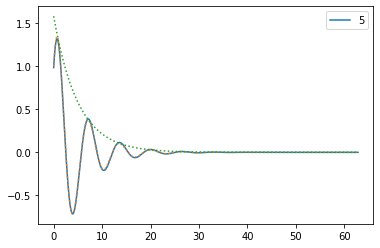

In [108]:
print(" ---- Begin ---- ")    
print("X0 = ", X)
print("    Error = ", compute_error(X_exact, X))
print("    Residuo = ", compute_residuo(tsample, xsample, X))

for zr in range(5):  # Numero de iteracoes
    # plot_current_solution(Xvec, zr)
    M, B = getMB(tsample, xsample, X)
    X -= np.linalg.solve(M, B)
    print(" ---- Iteration %d ---- " % (zr+1))
    print("X%d = " % (zr+1), X)
    print("    Error = ", compute_error(X_exact, X))
    print("    Residuo = ", compute_residuo(tsample, xsample, X))
print(" ---- Exato ----")
print("X = ", X_exact)
print("    Residuo = ", compute_residuo(tsample, xsample, X_exact))
plot_current_solution(X, zr+1)    
plt.legend()
plt.plot(tplot, xplot, ls="dotted")
C = np.sqrt(A_exact**2 + B_exact**2)
plt.plot(tplot, C*np.exp(-xi_exact*wn_exact*tplot), ls="dotted")

#### Variando condições iniciais

Agora vamos verificar se a nossa solução é adequada para diferentes valores das condições iniciais $(x_0, v_0)$.
Para deixar mais modularizado, vamos criar uma função que recebe os pontos $(t_i, \ x_i)$ e então devolve os valores estimados $(A, \ B, \ \xi, \ \omega)$.
No codigo acima consideramos fazer apenas $5$ iterações, mas neste colocaremos uma tolerância para a solução a ser encontrada.

Para algo mais genérico, a situação é mais complicada pois para encontrar $X_0$ dependemos de pegar os máximos e mínimos da função, e às vezes a incerteza da medição faz com que pegamos os valores e posições sejam errados.
Disso, vamos procuras as $3$ primerias raizes medidos, que com certeza teremos uma raiz entre picos:

In [112]:
def findRoots(xsample):
    index_raizes = []
    position = 0
    absxsample = np.abs(np.copy(xsample))
    for i in range(3):
        while xsample[position] * xsample[position+1] > 0:
            position += 1
        index_raizes.append(position)
        position += np.where(absxsample[position:] == np.max(absxsample[position:]))[0][0]
    return index_raizes

In [128]:
def regressaoQuadratica(tsample, xsample):
    n = len(tsample)
    L = np.ones((3, n))
    L[1] = xsample
    L[2] = xsample**2
    return np.linalg.solve(L @ L.T, L @ xsample)

def filter(xsample):
    n = len(xsample)
    m = n//100
    xfiltered = np.copy(xsample)
    for i in range(m, n-m):
        xfiltered[m+i] = np.mean(xsample[i:i+2*m])
    return xfiltered

In [129]:
def findInitialValues(tsample:np.ndarray, xsample:np.ndarray):
    index_raizes = findRoots(xsample)
    root0 = index_raizes[0]
    root1 = index_raizes[1]
    root2 = index_raizes[2]
    Td = 2*(tsample[root2] - tsample[root1])
    absxsample = np.copy(np.abs(xsample))
    alpha = np.where(absxsample[root1:root2] == np.max(absxsample[root1:root2]))[0][0] + root1
    beta = np.where(absxsample[root2:] == np.max(absxsample[root2:]))[0][0] + root2
    mu0wn0 = 2*np.pi/Td
    xi0wn0 = 2*np.log(absxsample[alpha]/absxsample[beta])/Td
    wn0 = np.sqrt(mu0wn0**2 + xi0wn0**2)
    xi0 = xi0wn0/wn0

    ind = np.max(10, root0//2)
    A0, _, _ = regressaoQuadratica(tsample[:ind], xsample[:ind])
    C0 = absxsample[alpha]/np.exp(-xi0*wn0*tsample[alpha])
    B0 = np.sqrt( np.abs(C0**2-A0**2) )
    X0 = np.array([A0, B0, xi0, wn0])
    print("X0 = ", X0)
    return X0

def SquareMinimum(tsample, xsample, tolerance=1e-6, nitermax = 10, verbose=True):
    X = findInitialValues(tsample, xsample)
    residuo = compute_residuo(tsample, xsample, X)
    if verbose:
        print(" ---- Begin ---- ")    
        print("    X0 = ", X)
        print("    Error = ", compute_error(X_exact, X))
        print("    Residuo = ", residuo)

    niter = 0
    for niter in range(nitermax)
        M, B = getMB(tsample, xsample, X)
        dX = np.linalg.solve(M, B)
        if X[2] - dX[2] <= 0:
            const = X[2]/np.abs(2*dX[2])
        elif X[2] - dX[2] >= 1:
            const = (1-X[2])/np.abs(2*dX[2])
        else:
            const = 1
        X -= const * dX
        newresiduo = compute_residuo(tsample, xsample, X)
        if verbose:
            print(" ---- Iteration %d ---- " % (zr+1))
            print("    X%d = " % (zr+1), X)
            print("    Error = ", compute_error(X_exact, X))
            print("    Residuo = ", compute_residuo(tsample, xsample, X))
        if np.abs(newresiduo - residuo) < tolerance:
            break
        if niter > nitermax:
            break
        residuo = newresiduo
        niter += 1
    except Exception as e:
        print("const = ", const)
        print("oldX[2] = ", X[2] + const*dX[2])
        print("newX[2] = ", X[2])
        print("  dX[2] = ", dX[2])
        print("    val = ", val)
        raise e
    return X

In [125]:
Tn = 2*np.pi/wn_exact
incerteza = 1e-3

x0s = np.linspace(-1, 1, 3)
v0s = np.linspace(-1, 1, 3)
residuos = np.zeros((len(x0s), len(v0s)))
nsample = 1001
tsample = np.linspace(0, 10*Tn, nsample)
for i, x0 in enumerate(x0s):
    for j, v0 in enumerate(v0s):
        print(f"(x0, v0) = ({x0}, {v0})")
        if (-0.3 < x0 < 0.3) and (-0.3< v0 < 0.3):
            continue
        xsample = solucao_x(xi_exact, wn_exact, x0, v0)(tsample)
        xsample += incerteza*(2*np.random.rand(nsample)-1)
        try:
            X = SquareMinimum(tsample, xsample, verbose=False)
        except Exception as e:
            print("(x0, v0) = (%.2f, %.2f)" % (x0, v0))
            raise e
        residuos[i, j] = compute_residuo(tsample, xsample, X)
fig, axes = plt.subplots()
c = axes.pcolormesh(x0s, v0s, residuos, shading="nearest")
fig.colorbar(c)

(x0, v0) = (-1.0, -1.0)
(x0, v0) = (-1.00, -1.00)


AxisError: axis 19 is out of bounds for array of dimension 0

E então podemos mudar os parâmetros $\xi$ e $\omega$, para avaliar o resíduo 